## 掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [2]:
# Change to your own folder !!!
# %cd /content/drive/MyDrive/your own folder/

## Import library

In [3]:
!pip install matplotlib



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

from models.resnet import ResNet50


## 設定超參數

In [5]:
SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 20
LEARNING_RATE = 1e-3
LOG_INTERVAL = 100
CUDA = True

RESUME = True
START_EPOCH = 0

PRUNE_PATH = 'model_prune.pth' # Change to your own folder !!!
PRUNE_FINETUNE_PATH = 'model_prune_finetune.pth' # Change to your own folder !!!


#### 檢查是否檢查是否可使用GPU

In [6]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [7]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 載入剪枝後的網路與權重

In [8]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  cfg = checkpoint['cfg']
  # # Debug print
  # for i in range(0, len(cfg), 3):
  #     print(f"Block {i//3}: {cfg[i]} {cfg[i+1]} {cfg[i+2]}")

  model = ResNet50(num_classes=10,cfg=cfg)
  # model = ResNet50(num_classes=10)
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


## 設定 Optimizer & CrossEntropy Loss

In [9]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 定義訓練跟測試函數

In [10]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
train_acc_list = []
test_acc_list = []

def train(epoch):
    model.train()
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % LOG_INTERVAL == 0:
            print('\nTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    acc = 100. * correct / total
    train_acc_list.append(acc)
    print(f"Train Accuracy: {acc:.2f}%")
    return acc


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    test_acc_list.append(acc)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    return acc


#### Fine-tune 訓練主迴圈 ####
best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # 動態調整學習率
    if epoch in [int(EPOCHS * 0.5), int(EPOCHS * 0.75)]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    train_acc = train(epoch)
    test_acc = test()

    # 儲存最佳模型
    if test_acc > best_prec1:
        best_prec1 = test_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
            'cfg': cfg
        }, PRUNE_FINETUNE_PATH)
    best_prec1 = max(test_acc, best_prec1)

print('\nTRAIN PRUNED MODEL DONE!')




Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.643360

Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.346796

Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.360213

Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.256285

Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.432739
Train Accuracy: 88.22%

Test set: Average loss: 0.3866, Accuracy: 8724/10000 (87.2%)


Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.423549

Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.258359

Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.225105

Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.220272

Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.301663
Train Accuracy: 89.42%

Test set: Average loss: 0.4300, Accuracy: 8631/10000 (86.3%)


Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.289483

Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.284888

Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.370222

Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.383138

Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.161532
Train Accuracy: 90.23%

Test set: Average loss: 

## 繪製Fine-tuning結果圖


In [11]:
save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)

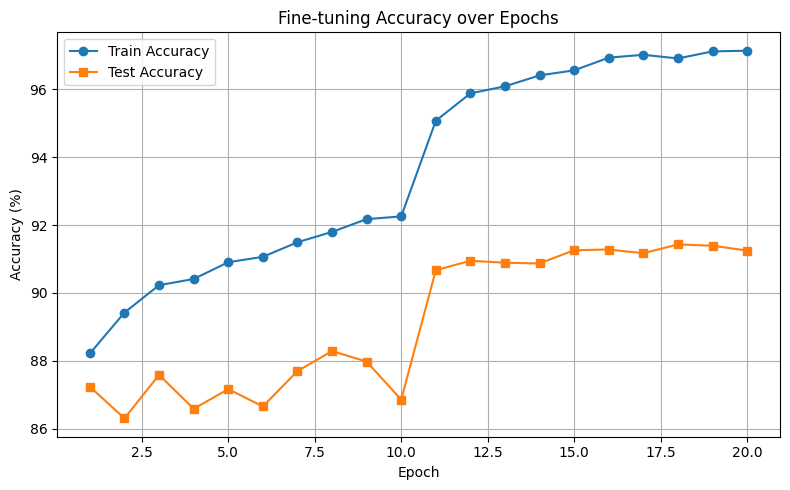

In [12]:
#繪製Fine-tuning結果圖
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy', marker='o')
plt.plot(range(1, len(test_acc_list) + 1), test_acc_list, label='Test Accuracy', marker='s')
plt.title('Fine-tuning Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
save_path = os.path.join(save_dir, f"fine_tune_result.png")
plt.savefig(save_path, dpi=300)
plt.show()

## FLOPs & Parameters

In [13]:
!pip install thop
!pip install torchsummary


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [14]:
from thop import profile
from torchsummary import summary

##### 使用 thop 計算 FLOPs 和參數數量 #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 138157592.0
Params: 3933678.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]           